In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

# First quarter

In [2]:
pdfirst = pd.read_csv('dataset/first_quarter.csv', index_col=0)

First all the products are aggregated per category, taking as price of the category the mean of the log(price_changes) 

In [3]:
ge=pdfirst.groupby(['comp_date','seller_id','coded_cat1'])['price_change_log'].mean().reset_index()
ge['comp_date'] = pd.to_datetime(ge['comp_date'])

pivot={}
for i in pdfirst['coded_cat1'].unique():
    pivot[i] = ge[ge['coded_cat1']==i].pivot(index='comp_date', columns='seller_id', values='price_change_log')

for i in pdfirst['coded_cat1'].unique():
    globals()['pivot{}'.format(i)] = pivot[i]

Dropping all the seller that have all null values for a specific category

In [4]:
c = 0
for i in pdfirst['coded_cat1'].unique():
    for j in globals()['pivot{}'.format(i)].columns:
        if np.isnan(globals()['pivot{}'.format(i)][j]).all() == True or (globals()['pivot{}'.format(i)][j]).sum() == 0:
            print(f'for the seller {j} the category {i} has all null values or zeros, so we drop it')
            globals()['pivot{}'.format(i)].drop(j, inplace=True, axis=1)
        else:
            c += 1

if c == 104:
    print('None of the category has all null values for each of sellers')

for the seller 490 the category 1375 has all null values or zeros, so we drop it
for the seller 490 the category 885 has all null values or zeros, so we drop it
for the seller 490 the category 1163 has all null values or zeros, so we drop it
for the seller 490 the category 1354 has all null values or zeros, so we drop it
for the seller 490 the category 2880 has all null values or zeros, so we drop it
for the seller 490 the category 624 has all null values or zeros, so we drop it
for the seller 490 the category 1617 has all null values or zeros, so we drop it
for the seller 188 the category 1776 has all null values or zeros, so we drop it
for the seller 490 the category 1776 has all null values or zeros, so we drop it


In [6]:
#fill na in all the pivot
for i in pdfirst['coded_cat1'].unique():
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(0)

# Analyzing all the different categories

- Check the stationarity of the time series
- Perform a cointegration test
- Implement a VAR model

## Pivot 1163

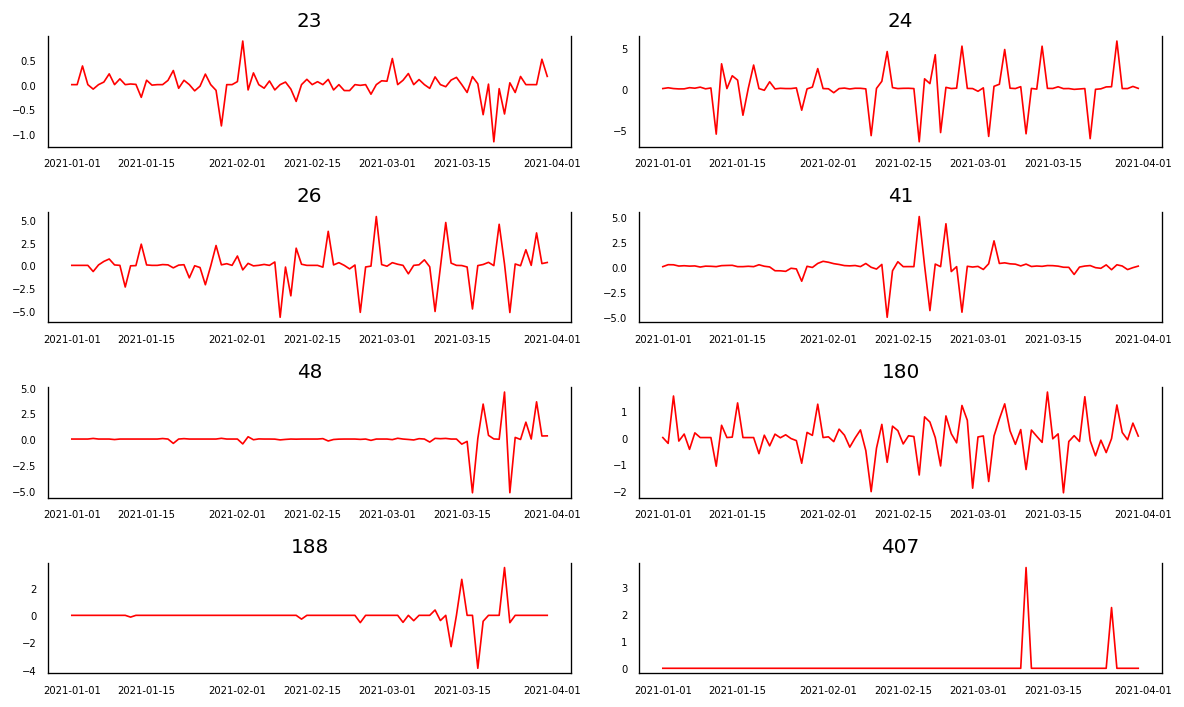

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1163[pivot1163.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot1163.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

They are time series on log change price, to see price changes during the series

### Performing Johanson's Cointegration Test

The Johansen test is used to test cointegrating relationships between several non-stationary time series data. Cointegration means that, while many developments can cause permanent changes in the individual variable, there is some long-run equilibrium relation tying the individual variables together, represented by some linear combination of them. So we performed this test to identify whether more than two-time series variables have some similar deterministic trends that can be combined over a period of time. Where it gives false, it means that we have no statistically significant relationship.

In [8]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

### Performing ADFuller Test

We performed this test to check the Stationarity of the time series. If we notices that a series was Non-Stationary we perform differencing to make it Stationary

In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [10]:
for name, column in pivot1163.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4926
 No. Lags Chosen       = 3
 Critical value 1%     = -3.509
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.836
 No. Lags Chosen       = 11
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [11]:
pivot1163 = pivot1163.diff().dropna()

After differencing all the time series are stationary

In [12]:
for name, column in pivot1163.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2835
 No. Lags Chosen       = 4
 Critical value 1%     = -3.511
 Critical value 5%     = -2.897
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6487
 No. Lags Chosen       = 12
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [13]:
cointegration_test(pivot1163)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  411.54    > 143.6691  =>   True
24     ::  305.13    > 111.7797  =>   True
26     ::  217.08    > 83.9383   =>   True
41     ::  141.23    > 60.0627   =>   True
48     ::  81.35     > 40.1749   =>   True
180    ::  38.36     > 24.2761   =>   True
188    ::  16.22     > 12.3212   =>   True
407    ::  3.52      > 4.1296    =>   False


### VAR model

Vector autoregression (VAR) is a statistical model used to capture the relationship between multiple quantities as they change over time. It is considered as an Autoregressive model because, each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series. In fact, the analyis of the coefficient (if they have a significan p-value) can help us predict another time series. We selected the number of lags according to the AIC, BIC, FPE and HQIC's results. 

In [14]:
#VAR model on df_pivot
model = VAR(pivot1163)
x = model.select_order(maxlags=8)
x.summary()

c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,2.869,3.105,17.62,2.964
1,0.5536,2.682,1.752,1.408
2,0.2261,4.246,1.319,1.839
3,-1.963,3.949,0.1659,0.4091
4,-2.520,5.284,0.1202,0.6111
5,-3.191,6.505,0.09358,0.6988
6,-5.509,6.079,0.01880,-0.8599
7,-8.527,4.953,0.003049,-3.119
8,-15.46*,-0.09272*,2.452e-05*,-9.297*


The VAR Order Selection identifies the appropriate number of lag, that we use to fit the model

In [15]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:07
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                 -0.0927232
Nobs:                     81.0000    HQIC:                  -9.29714
Log likelihood:           226.840    FPE:                2.45240e-05
AIC:                     -15.4645    Det(Omega_mle):     2.20114e-07
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.010806         0.023022           -0.469           0.639
L1.23         -0.863973         0.195940           -4.409           0.000
L1.24          0.052341         0.031935            1.639           0.101
L1.26         -0.

# PIVOT 1375

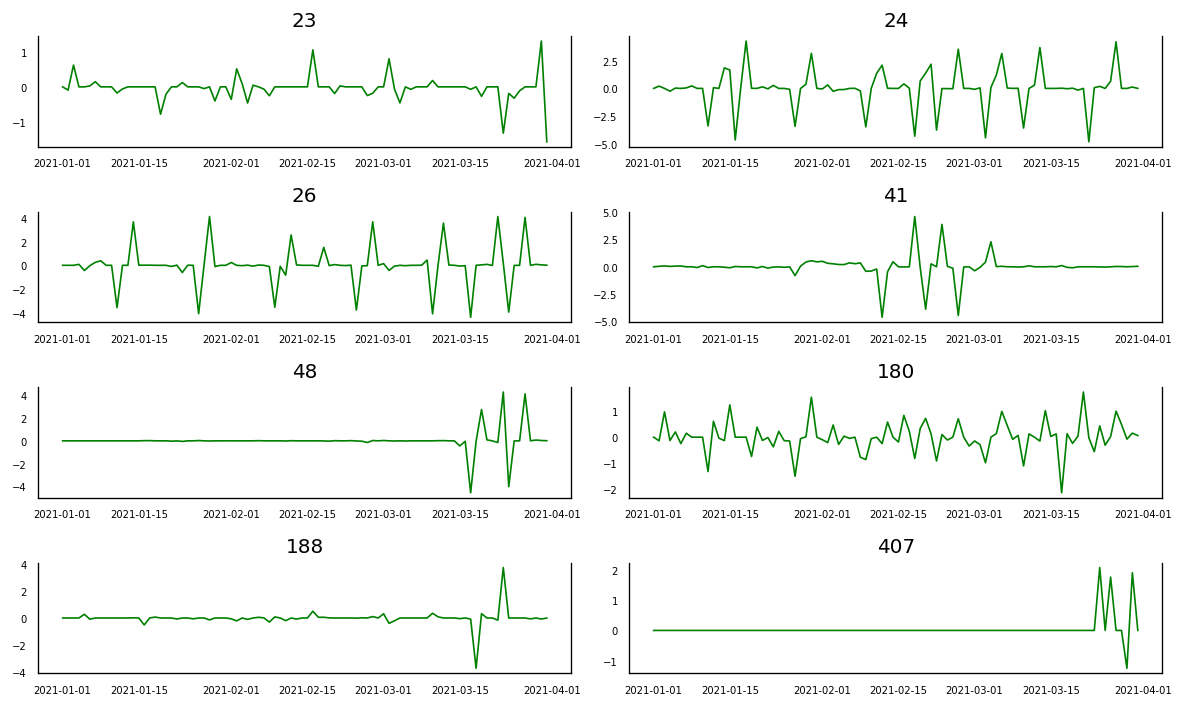

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1375[pivot1375.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1375.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

dropping the seller 407 because it has too many null values

In [17]:
pivot1375.drop(407,inplace=True,axis=1)

In [18]:
for name, column in pivot1375.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2681
 No. Lags Chosen       = 0
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.747
 No. Lags Chosen       = 11
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [19]:
pivot1375 = pivot1375.diff().dropna()

In [20]:
for name, column in pivot1375.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8545
 No. Lags Chosen       = 6
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1289
 No. Lags Chosen       = 12
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [21]:
cointegration_test(pivot1375)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  326.54    > 111.7797  =>   True
24     ::  225.72    > 83.9383   =>   True
26     ::  143.82    > 60.0627   =>   True
41     ::  97.29     > 40.1749   =>   True
48     ::  60.82     > 24.2761   =>   True
180    ::  32.59     > 12.3212   =>   True
188    ::  14.2      > 4.1296    =>   True


In [22]:

#VAR model on df_pivot
model = VAR(pivot1375)
x = model.select_order(maxlags=7)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,2.141,2.347,8.512,2.224
1,0.4476,2.091*,1.571,1.107
2,0.3082,3.390,1.401,1.545
3,-1.285,3.235,0.3041,0.5301
4,-1.858,4.100,0.1951,0.5343
5,-3.012,4.384,0.07701,-0.04232
6,-3.793,5.042,0.05075,-0.2458
7,-5.726*,4.547,0.01300*,-1.602*


In [23]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:13
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    4.54673
Nobs:                     82.0000    HQIC:                  -1.60156
Log likelihood:          -229.711    FPE:                  0.0129978
AIC:                     -5.72585    Det(Omega_mle):     0.000464035
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.005266         0.029802           -0.177           0.860
L1.23         -0.767669         0.178211           -4.308           0.000
L1.24          0.022915         0.034748            0.659           0.510
L1.26         -0.

# PIVOT 2180

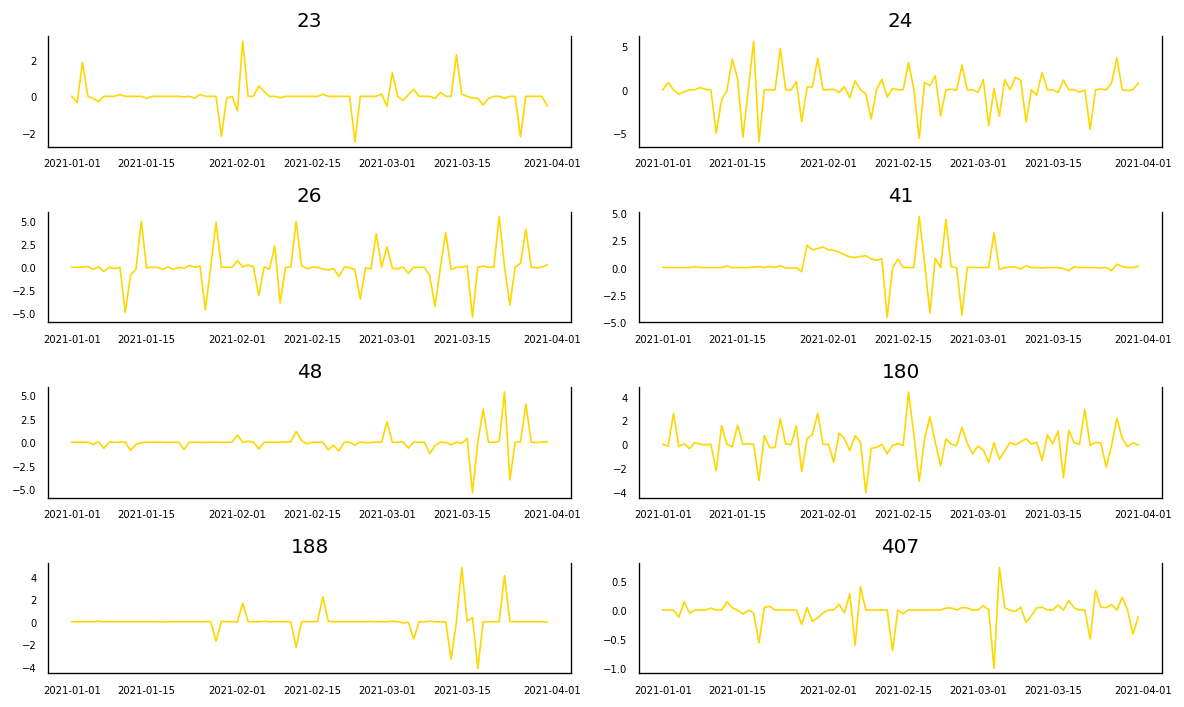

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2180[pivot2180.columns[i]]
    ax.plot(data, color='gold', linewidth=1)
    # Decorations
    ax.set_title(pivot2180.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [25]:
for name, column in pivot2180.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.0876
 No. Lags Chosen       = 0
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7161
 No. Lags Chosen       = 1
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [26]:
pivot2180 = pivot2180.diff().dropna()

In [27]:
for name, column in pivot2180.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1312
 No. Lags Chosen       = 4
 Critical value 1%     = -3.511
 Critical value 5%     = -2.897
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.4379
 No. Lags Chosen       = 7
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [28]:
cointegration_test(pivot2180)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  504.54    > 179.5199  =>   True
24     ::  381.71    > 143.6691  =>   True
26     ::  277.62    > 111.7797  =>   True
41     ::  215.9     > 83.9383   =>   True
48     ::  158.64    > 60.0627   =>   True
180    ::  112.27    > 40.1749   =>   True
188    ::  73.5      > 24.2761   =>   True
407    ::  41.09     > 12.3212   =>   True
490    ::  12.75     > 4.1296    =>   True


In [29]:

#VAR model on df_pivot
model = VAR(pivot2180)
x = model.select_order(maxlags=7)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,4.781,5.045*,119.2,4.887
1,2.860,5.501,17.65,3.920
2,2.445,7.464,12.46,4.460
3,0.3998,7.796,1.929,3.369
4,-0.2538,9.520,1.457,3.670
5,-1.808,10.34,0.6135,3.071
6,-2.787,11.74,0.7844,3.046
7,-6.825*,10.08,0.1307*,-0.03781*


In [30]:

model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:19
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    10.0805
Nobs:                     82.0000    HQIC:                -0.0378149
Log likelihood:          -191.343    FPE:                   0.130697
AIC:                     -6.82521    Det(Omega_mle):     0.000726798
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.001776         0.058701            0.030           0.976
L1.23         -0.325092         0.176779           -1.839           0.066
L1.24          0.177287         0.057370            3.090           0.002
L1.26         -0.

# PIVOT 1676

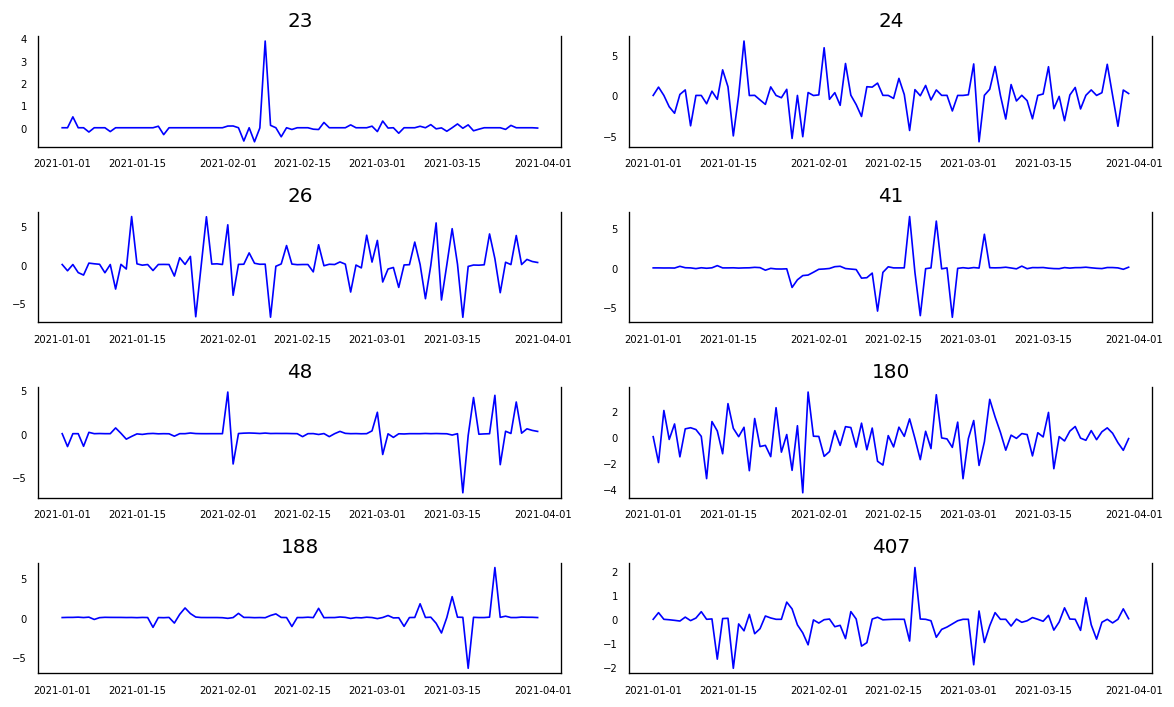

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1676[pivot1676.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(pivot1676.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In this specific case we observe that all the time series are stationary, so there is no need for differentiation

In [32]:
for name, column in pivot1676.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.2219
 No. Lags Chosen       = 0
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2212
 No. Lags Chosen       = 2
 Critical value 1%     = -3.508
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [33]:
cointegration_test(pivot1676)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  391.3     > 179.5199  =>   True
24     ::  271.12    > 143.6691  =>   True
26     ::  200.53    > 111.7797  =>   True
41     ::  143.64    > 83.9383   =>   True
48     ::  95.05     > 60.0627   =>   True
180    ::  61.82     > 40.1749   =>   True
188    ::  36.0      > 24.2761   =>   True
407    ::  17.0      > 12.3212   =>   True
490    ::  6.04      > 4.1296    =>   True


In [34]:

#VAR model on df_pivot
model = VAR(pivot1676)
x = model.select_order(maxlags=5)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,0.9151*,1.174*,2.497*,1.019*
1,1.221,3.807,3.423,2.261
2,1.770,6.684,6.291,3.747
3,2.352,9.594,13.22,5.265
4,1.997,11.57,12.90,5.846
5,1.473,13.37,13.97,6.259


In [35]:

model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:23
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    3.42074
Nobs:                     89.0000    HQIC:                   1.91851
Log likelihood:          -1086.80    FPE:                    2.49109
AIC:                     0.904143    Det(Omega_mle):        0.955393
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.049325         0.050774            0.971           0.331
L1.23          0.009947         0.111311            0.089           0.929
L1.24         -0.008297         0.024530           -0.338           0.735
L1.26          0.

 # PIVOT 2259

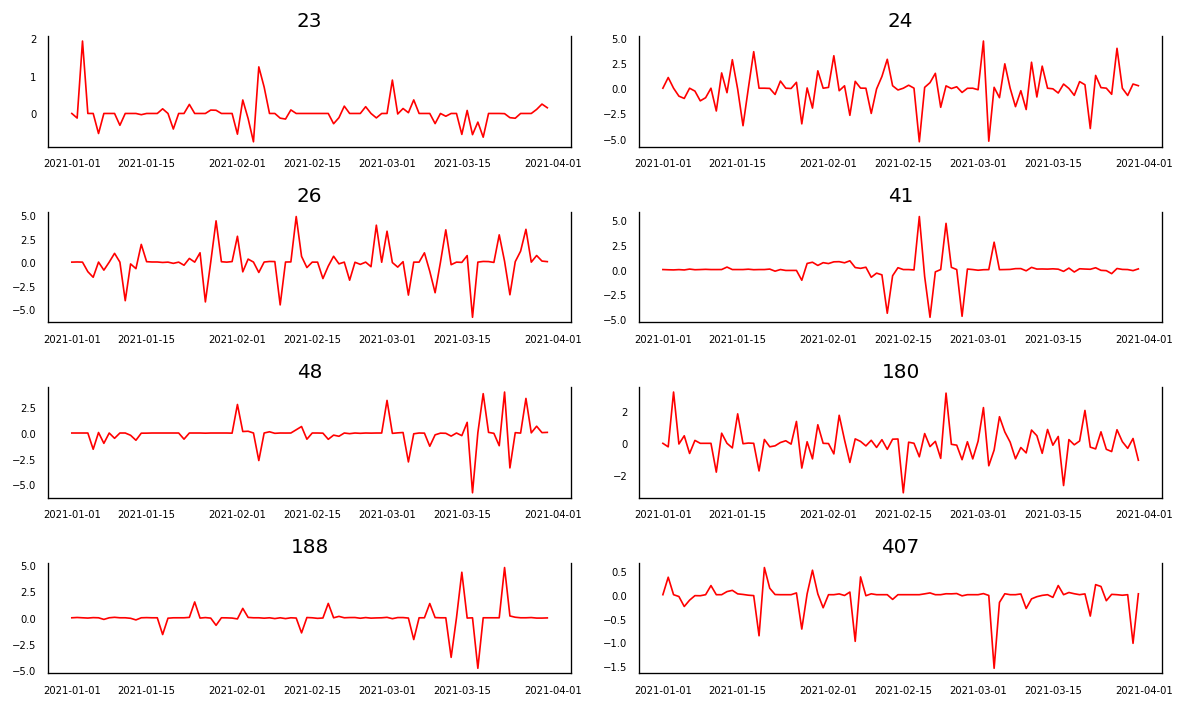

In [36]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2259[pivot2259.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot2259.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [37]:
 for name, column in pivot2259.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.4835
 No. Lags Chosen       = 0
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1832
 No. Lags Chosen       = 7
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [38]:
pivot2259 = pivot2259.diff().dropna()

In [39]:
 for name, column in pivot2259.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4142
 No. Lags Chosen       = 4
 Critical value 1%     = -3.511
 Critical value 5%     = -2.897
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4688
 No. Lags Chosen       = 12
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [40]:
cointegration_test(pivot2259)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  473.19    > 179.5199  =>   True
24     ::  361.17    > 143.6691  =>   True
26     ::  258.67    > 111.7797  =>   True
41     ::  189.86    > 83.9383   =>   True
48     ::  123.16    > 60.0627   =>   True
180    ::  80.62     > 40.1749   =>   True
188    ::  49.99     > 24.2761   =>   True
407    ::  28.07     > 12.3212   =>   True
490    ::  9.97      > 4.1296    =>   True


In [41]:

#VAR model on df_pivot
model = VAR(pivot2259)
x = model.select_order(maxlags=7)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,3.760,4.024*,42.95,3.866
1,1.588,4.229,4.948,2.648
2,0.9521,5.971,2.799,2.967
3,-0.1918,7.204,1.068,2.778
4,-1.104,8.670,0.6226,2.820
5,-2.296,9.855,0.3763,2.582
6,-3.206,11.32,0.5160,2.627
7,-9.417*,7.489,0.009788*,-2.629*


In [42]:

model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:28
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    7.48885
Nobs:                     82.0000    HQIC:                  -2.62949
Log likelihood:          -85.0844    FPE:                 0.00978847
AIC:                     -9.41688    Det(Omega_mle):     5.44332e-05
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.009549         0.032159           -0.297           0.767
L1.23         -0.634899         0.223181           -2.845           0.004
L1.24         -0.030366         0.049655           -0.612           0.541
L1.26         -0.

# PIVOT 885

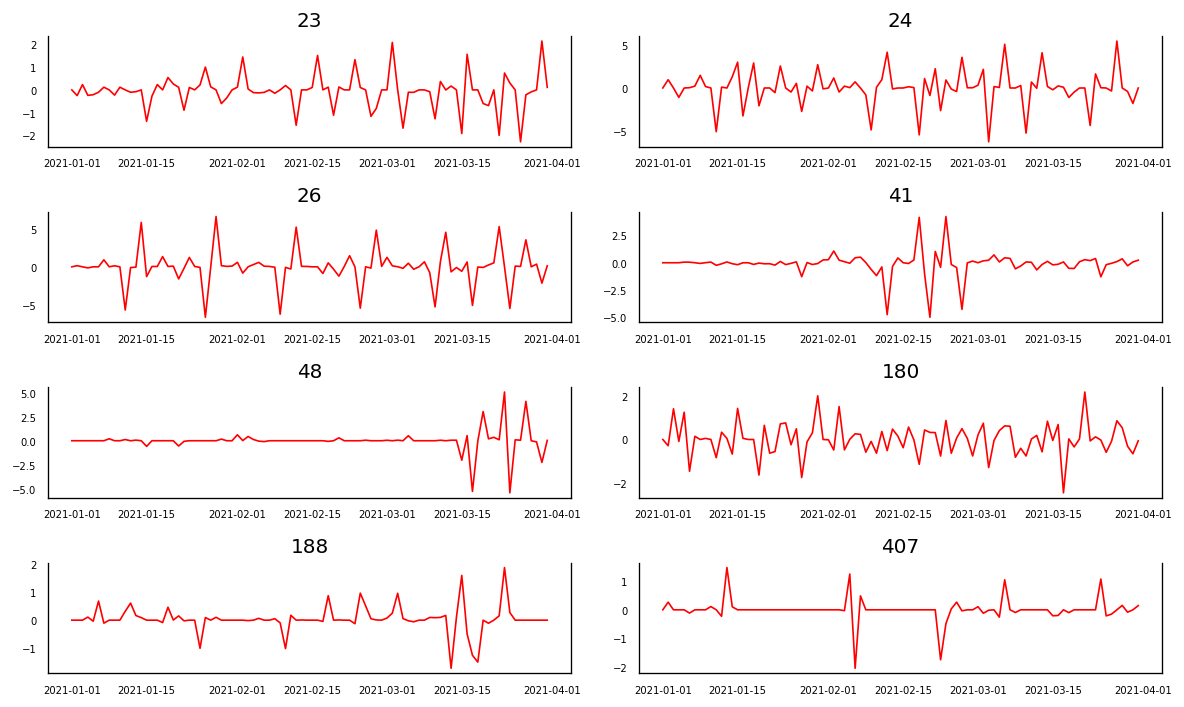

In [43]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot885[pivot885.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot885.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [44]:
 for name, column in pivot885.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8454
 No. Lags Chosen       = 11
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0521. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1458
 No. Lags Chosen       = 11
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signific

In [45]:
pivot885 = pivot885.diff().dropna()

In [46]:
 for name, column in pivot885.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1201
 No. Lags Chosen       = 10
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0251. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4988
 No. Lags Chosen       = 12
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [47]:
cointegration_test(pivot885)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  497.49    > 143.6691  =>   True
24     ::  371.82    > 111.7797  =>   True
26     ::  267.68    > 83.9383   =>   True
41     ::  182.96    > 60.0627   =>   True
48     ::  125.21    > 40.1749   =>   True
180    ::  75.46     > 24.2761   =>   True
188    ::  36.64     > 12.3212   =>   True
407    ::  17.98     > 4.1296    =>   True


In [48]:

#VAR model on df_pivot
model = VAR(pivot885)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,5.164,5.401*,174.9,5.259
1,3.290,5.419,27.05,4.144
2,3.056,7.076,22.34,4.669
3,1.837,7.749,7.414,4.209
4,1.889,9.693,9.879,5.020
5,0.9340,10.63,5.792,4.824
6,-0.7321,10.86,2.233,3.917
7,-2.672,10.81,1.064,2.736
8,-7.541*,7.831,0.06771*,-1.374*


In [49]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:33
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    7.83059
Nobs:                     81.0000    HQIC:                  -1.37383
Log likelihood:          -94.0542    FPE:                  0.0677083
AIC:                     -7.54118    Det(Omega_mle):     0.000607714
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.010261         0.059172           -0.173           0.862
L1.23         -0.978655         0.307141           -3.186           0.001
L1.24         -0.082028         0.078737           -1.042           0.298
L1.26         -0.

# PIVOT 2880

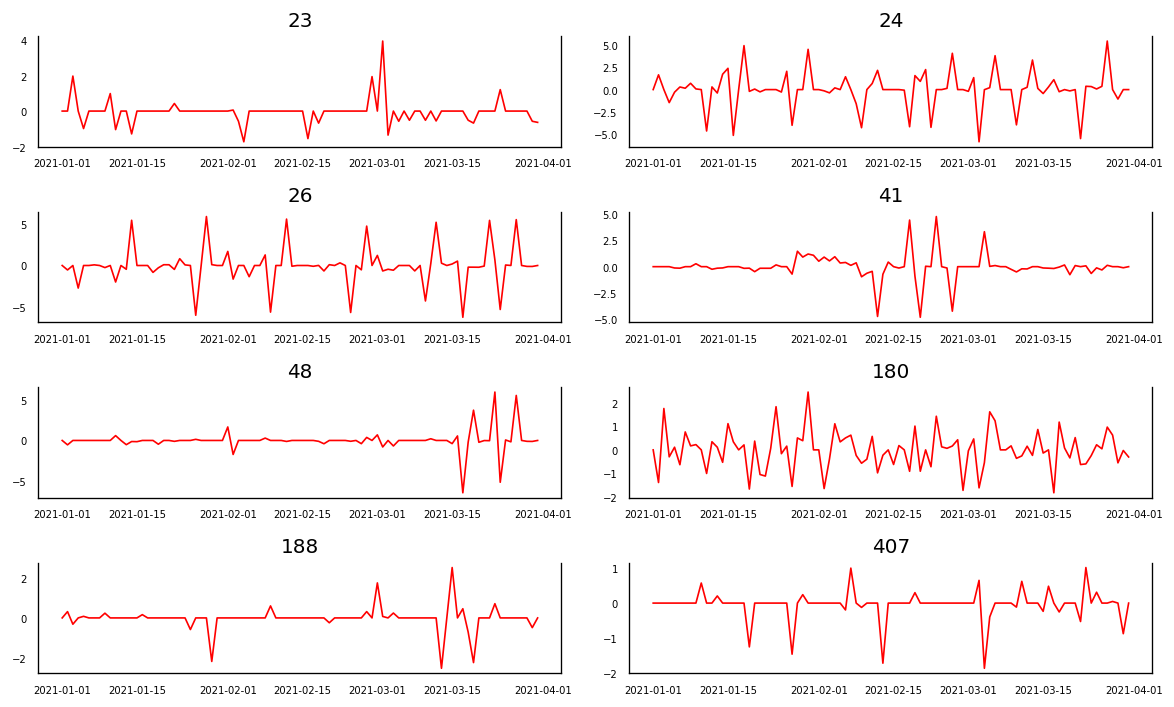

In [50]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2880[pivot2880.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot2880.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [51]:
    
for name, column in pivot2880.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6206
 No. Lags Chosen       = 1
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.3694
 No. Lags Chosen       = 4
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [52]:
pivot2880 = pivot2880.diff().dropna()

In [53]:
    
for name, column in pivot2880.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5837
 No. Lags Chosen       = 5
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3349
 No. Lags Chosen       = 11
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [54]:
cointegration_test(pivot2880)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  421.63    > 143.6691  =>   True
24     ::  318.47    > 111.7797  =>   True
26     ::  246.76    > 83.9383   =>   True
41     ::  180.56    > 60.0627   =>   True
48     ::  123.62    > 40.1749   =>   True
180    ::  71.97     > 24.2761   =>   True
188    ::  40.6      > 12.3212   =>   True
407    ::  19.12     > 4.1296    =>   True


In [55]:

#VAR model on df_pivot
model = VAR(pivot2880)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,5.490,5.726,242.2,5.585
1,3.565,5.694*,35.62,4.419
2,3.652,7.672,40.55,5.265
3,2.547,8.459,15.08,4.919
4,1.782,9.586,8.878,4.913
5,2.041,11.74,17.53,5.931
6,0.8188,12.41,10.53,5.468
7,-0.6555,12.82,7.995,4.753
8,-5.018*,10.35,0.8442*,1.149*


In [56]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:39
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    10.3538
Nobs:                     81.0000    HQIC:                   1.14941
Log likelihood:          -196.245    FPE:                   0.844244
AIC:                     -5.01795    Det(Omega_mle):      0.00757749
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.005556         0.070176           -0.079           0.937
L1.23         -0.435485         0.233627           -1.864           0.062
L1.24          0.122550         0.085557            1.432           0.152
L1.26          0.

# PIVOT 1127

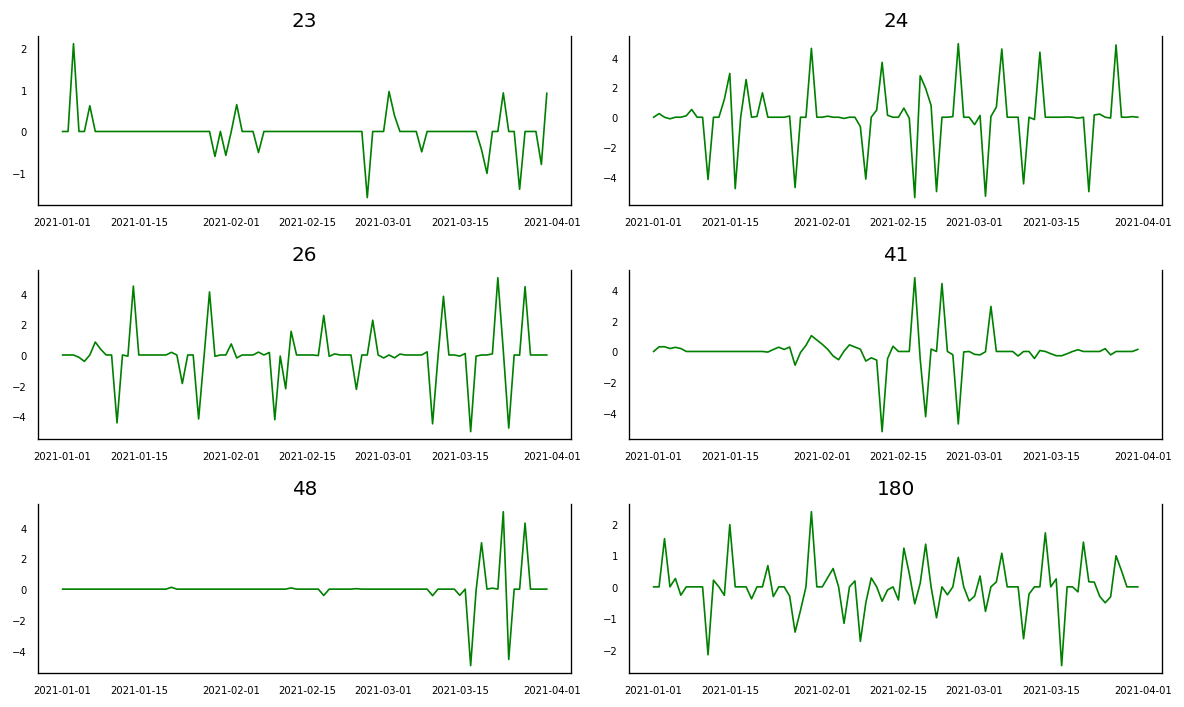

In [57]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1127[pivot1127.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1127.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [58]:
for name, column in pivot1127.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7325
 No. Lags Chosen       = 4
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1834
 No. Lags Chosen       = 11
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

dropping sellers 188 and 490 because they have too many null values

In [59]:
pivot1127.drop(188,inplace=True,axis=1)
pivot1127.drop(490,inplace=True,axis=1)

In [60]:
pivot1127 = pivot1127.diff().dropna()

In [61]:
for name, column in pivot1127.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.4086
 No. Lags Chosen       = 8
 Critical value 1%     = -3.515
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3143
 No. Lags Chosen       = 12
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [62]:
cointegration_test(pivot1127)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  333.93    > 83.9383   =>   True
24     ::  240.72    > 60.0627   =>   True
26     ::  159.53    > 40.1749   =>   True
41     ::  107.23    > 24.2761   =>   True
48     ::  57.75     > 12.3212   =>   True
180    ::  23.29     > 4.1296    =>   True


In [63]:

#VAR model on df_pivot
model = VAR(pivot1127)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,4.350,4.528,77.51,4.422
1,3.045,4.287*,21.06,3.543
2,3.053,5.359,21.54,3.978
3,2.052,5.422,8.208,3.404*
4,2.052,6.486,8.814,3.831
5,2.023,7.522,9.677,4.229
6,1.206,7.768,5.171*,3.839
7,0.9624*,8.589,5.410,4.022
8,1.046,9.737,8.999,4.532


In [64]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:43
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    9.73651
Nobs:                     81.0000    HQIC:                   4.53247
Log likelihood:          -437.949    FPE:                    8.99866
AIC:                      1.04554    Det(Omega_mle):        0.526536
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.007518         0.036740           -0.205           0.838
L1.23         -0.747028         0.195473           -3.822           0.000
L1.24         -0.067581         0.034383           -1.966           0.049
L1.26          0.

# PIVOT 1354

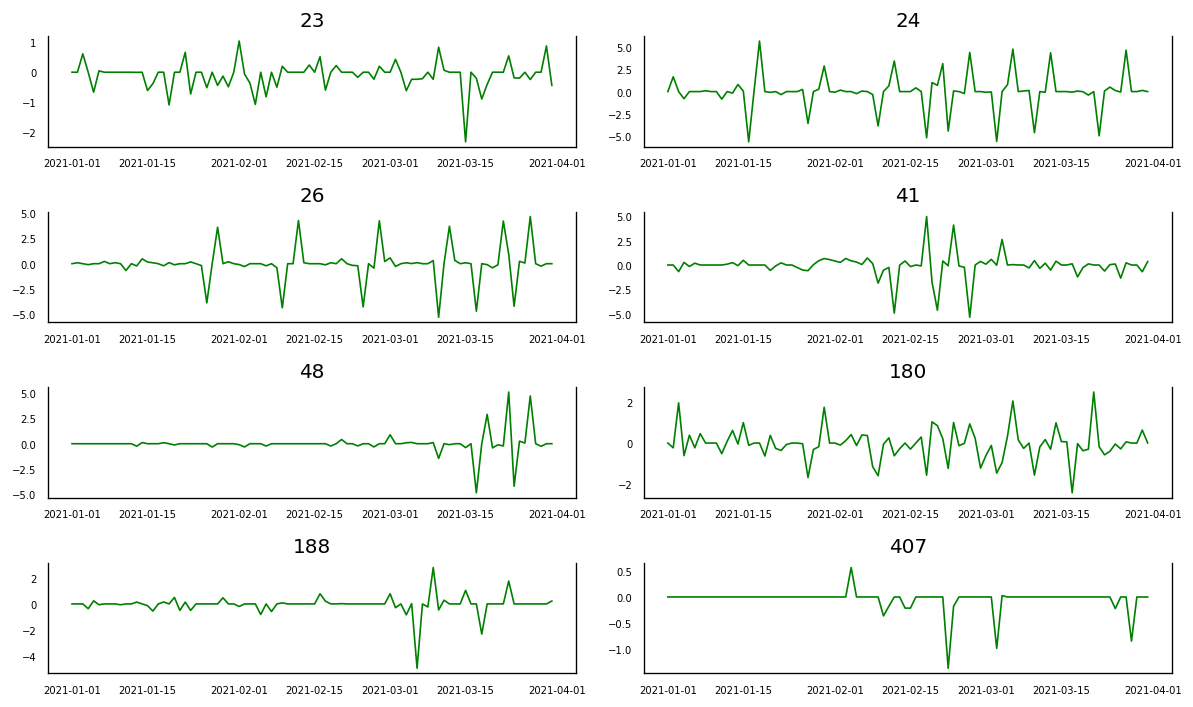

In [65]:

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1354[pivot1354.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1354.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [66]:
  
for name, column in pivot1354.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8083
 No. Lags Chosen       = 0
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0372
 No. Lags Chosen       = 11
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [67]:
pivot1354 = pivot1354.diff().dropna()

In [68]:
  
for name, column in pivot1354.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9716
 No. Lags Chosen       = 9
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8573
 No. Lags Chosen       = 11
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [69]:
cointegration_test(pivot1354)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  524.89    > 143.6691  =>   True
24     ::  373.44    > 111.7797  =>   True
26     ::  252.56    > 83.9383   =>   True
41     ::  172.06    > 60.0627   =>   True
48     ::  120.63    > 40.1749   =>   True
180    ::  82.27     > 24.2761   =>   True
188    ::  46.8      > 12.3212   =>   True
407    ::  19.62     > 4.1296    =>   True


In [70]:

#VAR model on df_pivot
model = VAR(pivot1354)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,2.445,2.682*,11.53,2.540
1,0.8552,2.984,2.369,1.709
2,0.9051,4.925,2.601,2.518
3,-0.6504,5.262,0.6163,1.722
4,-0.8020,7.002,0.6700,2.329
5,-1.526,8.170,0.4949,2.364
6,-3.707,7.881,0.1140,0.9421
7,-5.885,7.595,0.04284,-0.4763
8,-9.143*,6.229,0.01365*,-2.976*


In [71]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:48
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    6.22883
Nobs:                     81.0000    HQIC:                  -2.97559
Log likelihood:          -29.1829    FPE:                  0.0136460
AIC:                     -9.14294    Det(Omega_mle):     0.000122479
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.003587         0.040943           -0.088           0.930
L1.23         -0.833037         0.299812           -2.779           0.005
L1.24         -0.138422         0.049117           -2.818           0.005
L1.26          0.

# PIVOT 1617

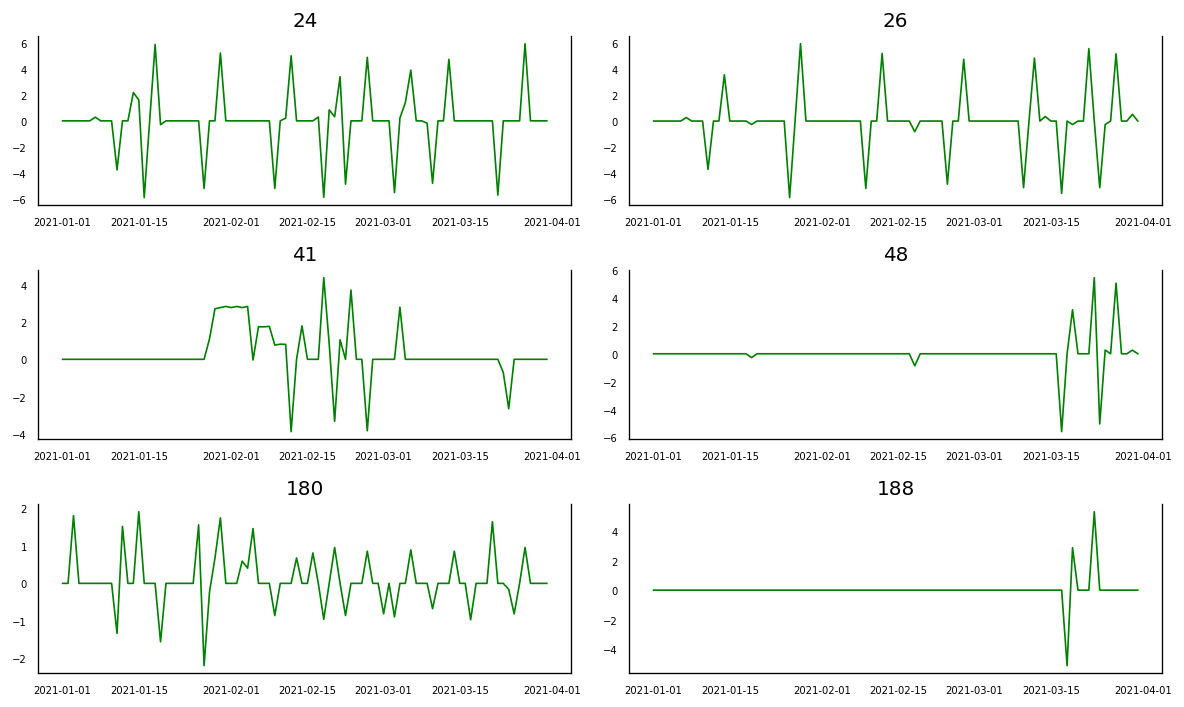

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1617[pivot1617.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1617.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [73]:
   
for name, column in pivot1617.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1081
 No. Lags Chosen       = 11
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.4321
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [74]:
cointegration_test(pivot1617)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  209.01    > 111.7797  =>   True
26     ::  143.4     > 83.9383   =>   True
41     ::  96.83     > 60.0627   =>   True
48     ::  66.26     > 40.1749   =>   True
180    ::  39.71     > 24.2761   =>   True
188    ::  18.28     > 12.3212   =>   True
407    ::  5.7       > 4.1296    =>   True


In [75]:

#VAR model on df_pivot
model = VAR(pivot1617)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,0.9651,1.171*,2.625,1.048
1,0.7544,2.398,2.136,1.414
2,1.288,4.369,3.731,2.525
3,1.307,5.827,4.061,3.122
4,0.9374,6.896,3.193,3.329
5,-1.108,6.288,0.5166,1.861
6,-1.141,7.694,0.7198,2.406
7,-1.839,8.434,0.6340,2.286
8,-4.016*,7.695,0.1758*,0.6858*


In [76]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:52
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    7.69487
Nobs:                     82.0000    HQIC:                  0.685814
Log likelihood:          -250.820    FPE:                   0.175803
AIC:                     -4.01587    Det(Omega_mle):      0.00437139
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.219761         0.418091           -0.526           0.599
L1.24         -0.331449         0.217899           -1.521           0.128
L1.26          0.398057         0.300674            1.324           0.186
L1.41         -0.

# PIVOT 1776

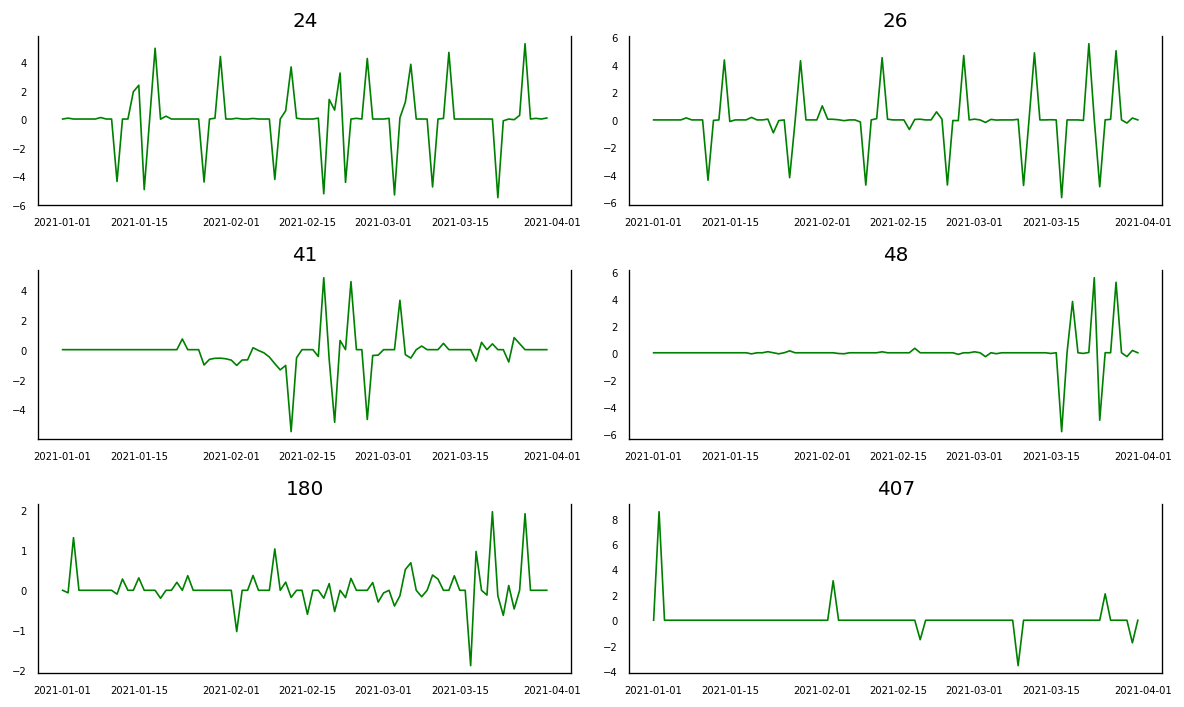

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1776[pivot1776.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1776.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [78]:
for name, column in pivot1776.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9838
 No. Lags Chosen       = 11
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1623
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [79]:
pivot1776 = pivot1776.diff().dropna()

In [80]:
for name, column in pivot1776.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.32
 No. Lags Chosen       = 12
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8991
 No. Lags Chosen       = 12
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Stat

In [81]:
cointegration_test(pivot1776)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  297.9     > 83.9383   =>   True
26     ::  201.1     > 60.0627   =>   True
41     ::  136.73    > 40.1749   =>   True
48     ::  89.04     > 24.2761   =>   True
180    ::  52.62     > 12.3212   =>   True
407    ::  23.01     > 4.1296    =>   True


In [82]:

#VAR model on df_pivot
model = VAR(pivot1776)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,5.768,5.945,319.9,5.839
1,4.321,5.563*,75.48,4.819
2,4.117,6.423,62.42,5.042
3,3.107,6.477,23.58,4.459*
4,3.052,7.486,23.96,4.831
5,2.730,8.228,19.61,4.936
6,2.213,8.776,14.17,4.846
7,1.846,9.472,13.08,4.906
8,1.311*,10.00,11.73*,4.798


In [83]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:35:56
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    10.0019
Nobs:                     81.0000    HQIC:                   4.79786
Log likelihood:          -448.697    FPE:                    11.7337
AIC:                      1.31093    Det(Omega_mle):        0.686567
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.079067         0.283559            0.279           0.780
L1.24         -0.998251         0.203007           -4.917           0.000
L1.26          0.360374         0.242728            1.485           0.138
L1.41         -0.

# PIVOT 624

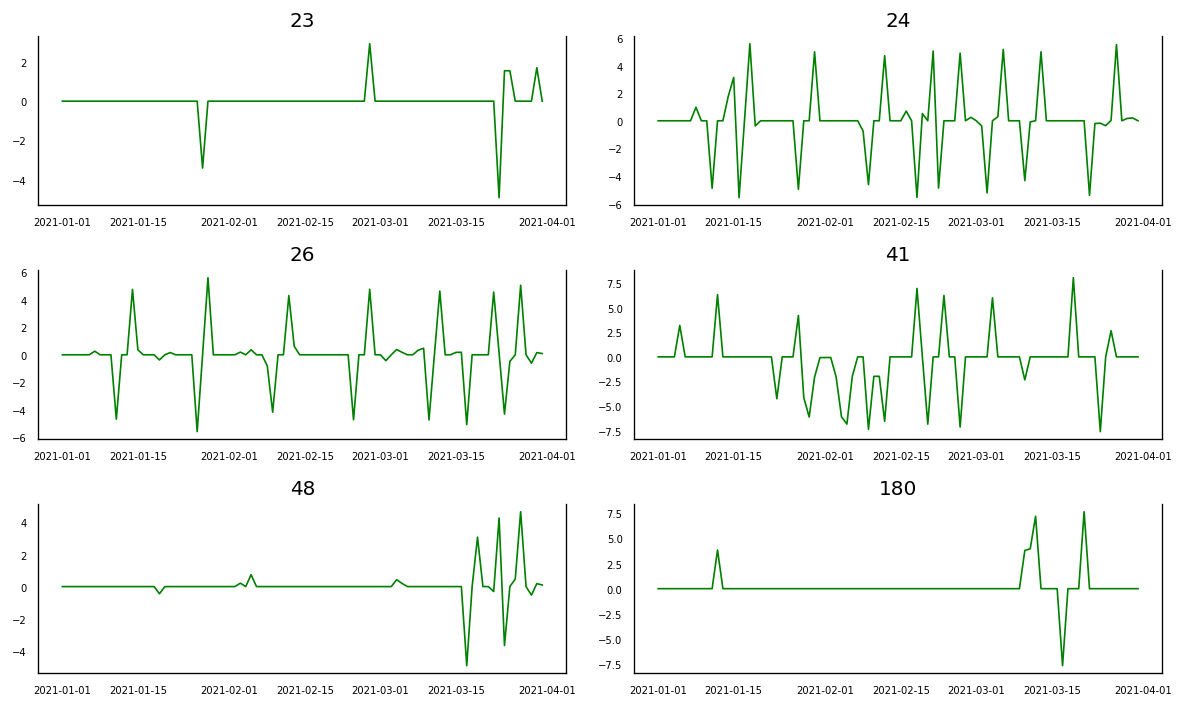

In [84]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot624[pivot624.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot624.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

dropping the seller 407 because it has too many null values

In [85]:
pivot624.drop(407,inplace=True,axis=1)

In [86]:
 
for name, column in pivot624.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9612
 No. Lags Chosen       = 1
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0567
 No. Lags Chosen       = 11
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [87]:
pivot624 = pivot624.diff().dropna()

In [88]:
 
for name, column in pivot624.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8599
 No. Lags Chosen       = 4
 Critical value 1%     = -3.511
 Critical value 5%     = -2.897
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4345
 No. Lags Chosen       = 12
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [89]:
cointegration_test(pivot624)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  333.14    > 111.7797  =>   True
24     ::  235.76    > 83.9383   =>   True
26     ::  164.94    > 60.0627   =>   True
41     ::  106.62    > 40.1749   =>   True
48     ::  55.3      > 24.2761   =>   True
180    ::  28.07     > 12.3212   =>   True
188    ::  5.59      > 4.1296    =>   True


In [90]:

#VAR model on df_pivot
model = VAR(pivot624)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,8.204,8.410*,3654.,8.287
1,6.844,8.500,942.7,7.508
2,6.329,9.433,577.8,7.574
3,5.404,9.957,245.2,7.231
4,4.943,10.94,176.8,7.350
5,4.794,12.24,192.6,7.783
6,3.527,12.43,79.37,7.097
7,2.587,12.93,56.43,6.738
8,1.158*,12.95,34.84*,5.891*


In [91]:

model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     23:36:00
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    10.3758
Nobs:                     85.0000    HQIC:                   6.88859
Log likelihood:          -834.310    FPE:                    114.617
AIC:                      4.54214    Det(Omega_mle):         14.6842
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.029579         0.082591            0.358           0.720
L1.23         -0.842467         0.159389           -5.286           0.000
L1.24          0.106502         0.040237            2.647           0.008
L1.26          0.

# Grangers causation coded_cat1

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another

In [92]:
from statsmodels.tsa.stattools import grangercausalitytests

Function build to have the grangers matrix

In [93]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=8
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
        df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for c in df.columns:
            for r in df.index:
                test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                df.loc[r, c] = min_p_value
        df.columns = [var for var in variables]
        df.index = [var  for var in variables]
        return df

compute the grangers causalty test for each of the category

For the intepretation of the granger casuality matrix we look at the values and select the ones that are less than 0.05. We then look at the sellers in the column and the row: the seller on the column will granger cause the one on the row. For example: looking at the second row we have 0.0272 for sellers 23 and 24. Since 23 is in the column and 24 in the rows, we can say that 23 granger cause 24. Of course this would be for the category 2259, because the matrix is built on each pivot representing categories of products

Follow an example of the grangers matrix for the 1163 category

In [94]:
grangers_causation_matrix(pivot1163, variables = pivot1163.columns)

,23,24,26,41,48,180,188,407
23,1.0000,0.2908,0.0587,0.7480,0.2315,0.0385,0.0000,0.0093
24,0.2041,1.0000,0.0183,0.0517,0.0262,0.4113,0.0122,0.2761
26,0.5062,0.0053,1.0000,0.0000,0.0347,0.0140,0.0055,0.0434
41,0.9130,0.0188,0.0017,1.0000,0.7083,0.0671,0.8871,0.9933
48,0.0013,0.0343,0.0000,0.9811,1.0000,0.0047,0.0000,0.0000
180,0.5419,0.3084,0.1127,0.0066,0.5388,1.0000,0.0000,0.0019
188,0.0494,0.0361,0.0001,0.9676,0.0000,0.0013,1.0000,0.0000
407,0.1712,0.7012,0.1291,0.8422,0.0014,0.0665,0.0027,1.0000


Computing the matrices for all the categories

In [95]:
for i in pdfirst.coded_cat1.unique():
    globals()['grangers{}'.format(i)] = grangers_causation_matrix(globals()['pivot{}'.format(i)], variables = globals()['pivot{}'.format(i)].columns)

Based on the grangers causation:

In [96]:
print('Accordingly to the grangers causalty test:')

for j in pdfirst.coded_cat1.unique():
    print(f'\n In the category {j}')
    for i in globals()['grangers{}'.format(j)].columns:
        if len(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values) > 0:
            print(f'Seller {i} is the leader and', globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values ,'followers')
        else:
            print(f'Seller {i} has no follower')

Accordingly to the grangers causalty test:

 In the category 1375
Seller 23 is the leader and [24 26 41] followers
Seller 24 is the leader and [23 41] followers
Seller 26 is the leader and [ 23  24  48 180 188] followers
Seller 41 is the leader and [23 26] followers
Seller 48 is the leader and [ 23 188] followers
Seller 180 is the leader and [ 24  26  48 188] followers
Seller 188 is the leader and [ 23  24  26  48 180] followers

 In the category 2180
Seller 23 is the leader and [ 48 188 490] followers
Seller 24 is the leader and [41] followers
Seller 26 is the leader and [ 23  48 188 490] followers
Seller 41 is the leader and [180 407] followers
Seller 48 is the leader and [ 23 188 407 490] followers
Seller 180 is the leader and [188 490] followers
Seller 188 is the leader and [ 48 180 407 490] followers
Seller 407 is the leader and [188 490] followers
Seller 490 is the leader and [23 26 48] followers

 In the category 1676
Seller 23 is the leader and [ 26  41 407] followers
Seller 24

Insert the results into a DataFrame: the dataframe show the followers of each seller (leader), on columns, for each category

In [97]:
leader = {}
for j in pdfirst.coded_cat1.unique():
    follower = {}
    for i in globals()['grangers{}'.format(j)].columns:
        if len(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values) > 0:
            follower[i] = list(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values)
    leader[j] = follower           

matrix = pd.DataFrame(leader).T
matrix

,23,24,26,41,48,180,188,407,490
1375,"[24, 26, 41]","[23, 41]","[23, 24, 48, 180, 188]","[23, 26]","[23, 188]","[24, 26, 48, 188]","[23, 24, 26, 48, 180]",NaN,NaN
2180,"[48, 188, 490]",[41],"[23, 48, 188, 490]","[180, 407]","[23, 188, 407, 490]","[188, 490]","[48, 180, 407, 490]","[188, 490]","[23, 26, 48]"
1676,"[26, 41, 407]","[23, 26]","[24, 48, 188, 490]","[26, 180, 407]","[23, 24, 188, 490]",[26],"[48, 490]",[24],[188]
885,"[24, 26, 48, 180]","[23, 26]","[23, 24, 48, 180]","[23, 26, 407]","[23, 24, 188]","[23, 26, 48, 407]","[23, 48]","[23, 41]",NaN
1163,"[48, 188]","[26, 41, 48, 188]","[24, 41, 48, 188]","[26, 180]","[24, 26, 188, 407]","[23, 26, 48, 188]","[23, 24, 26, 48, 180, 407]","[23, 26, 48, 180, 188]",NaN
2259,[26],"[26, 41, 48, 407]","[24, 48, 188, 407, 490]","[24, 26]","[24, 188, 407, 490]","[24, 26, 41, 407, 490]","[26, 48, 490]",NaN,"[24, 48, 188]"
1354,"[26, 48, 188]","[188, 407]","[23, 41, 48, 180, 188]","[26, 180, 188, 407]","[26, 188]","[26, 48]","[23, 24, 26, 48]","[24, 41, 188]",NaN
1127,"[24, 26, 48, 180]","[23, 41]","[23, 24, 48, 180]",NaN,[23],"[23, 48]",NaN,NaN,NaN
2880,"[24, 180, 407]","[26, 41]","[23, 48, 188, 407]","[23, 26, 407]",[26],"[24, 26, 41, 188, 407]","[23, 26, 48, 180, 407]","[48, 180]",NaN
624,"[41, 48]","[23, 41, 188]","[24, 48, 180, 188]","[23, 188]","[23, 180, 188]","[23, 26, 41, 48, 188]","[24, 26, 41, 48, 180]",NaN,NaN


computing the more recurrent follower for each seller, and counting in how many categories is the follower

In [98]:
matrix0 = matrix.fillna(0)
follower_mode = []
for i in matrix0.columns:
    mode=[]
    for j in matrix0.index:
        if matrix0[i][j] != 0:
            for g in range(len(matrix0[i][j])):
                mode.append(matrix0[i][j][g])
    print(f'The more recurrent follower for seller {i} is {max(set(mode), key=mode.count)}, that is a follower in {mode.count(max(set(mode), key=mode.count))} categories')
    follower_mode.append(max(set(mode), key=mode.count))

The more recurrent follower for seller 23 is 48, that is a follower in 6 categories
The more recurrent follower for seller 24 is 41, that is a follower in 9 categories
The more recurrent follower for seller 26 is 48, that is a follower in 12 categories
The more recurrent follower for seller 41 is 26, that is a follower in 8 categories
The more recurrent follower for seller 48 is 188, that is a follower in 9 categories
The more recurrent follower for seller 180 is 26, that is a follower in 9 categories
The more recurrent follower for seller 188 is 48, that is a follower in 10 categories
The more recurrent follower for seller 407 is 48, that is a follower in 3 categories
The more recurrent follower for seller 490 is 48, that is a follower in 2 categories


In [99]:
matrix2 = matrix.append(pd.Series(follower_mode, index=matrix.columns, name='followers mode'))

Adding the percentage of the time a seller is leader and the more reccurrent follower to the dataframe

In [100]:
matrix2

,23,24,26,41,48,180,188,407,490
1375,"[24, 26, 41]","[23, 41]","[23, 24, 48, 180, 188]","[23, 26]","[23, 188]","[24, 26, 48, 188]","[23, 24, 26, 48, 180]",NaN,NaN
2180,"[48, 188, 490]",[41],"[23, 48, 188, 490]","[180, 407]","[23, 188, 407, 490]","[188, 490]","[48, 180, 407, 490]","[188, 490]","[23, 26, 48]"
1676,"[26, 41, 407]","[23, 26]","[24, 48, 188, 490]","[26, 180, 407]","[23, 24, 188, 490]",[26],"[48, 490]",[24],[188]
885,"[24, 26, 48, 180]","[23, 26]","[23, 24, 48, 180]","[23, 26, 407]","[23, 24, 188]","[23, 26, 48, 407]","[23, 48]","[23, 41]",NaN
1163,"[48, 188]","[26, 41, 48, 188]","[24, 41, 48, 188]","[26, 180]","[24, 26, 188, 407]","[23, 26, 48, 188]","[23, 24, 26, 48, 180, 407]","[23, 26, 48, 180, 188]",NaN
2259,[26],"[26, 41, 48, 407]","[24, 48, 188, 407, 490]","[24, 26]","[24, 188, 407, 490]","[24, 26, 41, 407, 490]","[26, 48, 490]",NaN,"[24, 48, 188]"
1354,"[26, 48, 188]","[188, 407]","[23, 41, 48, 180, 188]","[26, 180, 188, 407]","[26, 188]","[26, 48]","[23, 24, 26, 48]","[24, 41, 188]",NaN
1127,"[24, 26, 48, 180]","[23, 41]","[23, 24, 48, 180]",NaN,[23],"[23, 48]",NaN,NaN,NaN
2880,"[24, 180, 407]","[26, 41]","[23, 48, 188, 407]","[23, 26, 407]",[26],"[24, 26, 41, 188, 407]","[23, 26, 48, 180, 407]","[48, 180]",NaN
624,"[41, 48]","[23, 41, 188]","[24, 48, 180, 188]","[23, 188]","[23, 180, 188]","[23, 26, 41, 48, 188]","[24, 26, 41, 48, 180]",NaN,NaN


# Plot

Sorting the product based on the number of time the price was changed for that product

In [101]:
pdfirst0 = pdfirst.fillna(0)
pdfirst0['price_change_sign'] = np.where(pdfirst.price_change == 0, 1, 0)
prod_p_var = pdfirst0.groupby(['product_id','coded_cat1'])['price_change_sign'].sum()
prod_p_var = pd.DataFrame(prod_p_var)
prod_p_var.reset_index(inplace=True)
prod_p_var.sort_values('price_change_sign', ascending=False, inplace=True)

In [102]:
prod_p_var[prod_p_var.coded_cat1 == 1163].head(20)

,product_id,coded_cat1,price_change_sign
2012,141764,1163,512
393,108284,1163,509
2719,150562,1163,505
2679,149415,1163,482
2562,146253,1163,479
1285,131969,1163,477
2173,142695,1163,469
2342,143842,1163,463
1923,140162,1163,460
3318,155833,1163,450


<AxesSubplot: xlabel='comp_date', ylabel='price'>

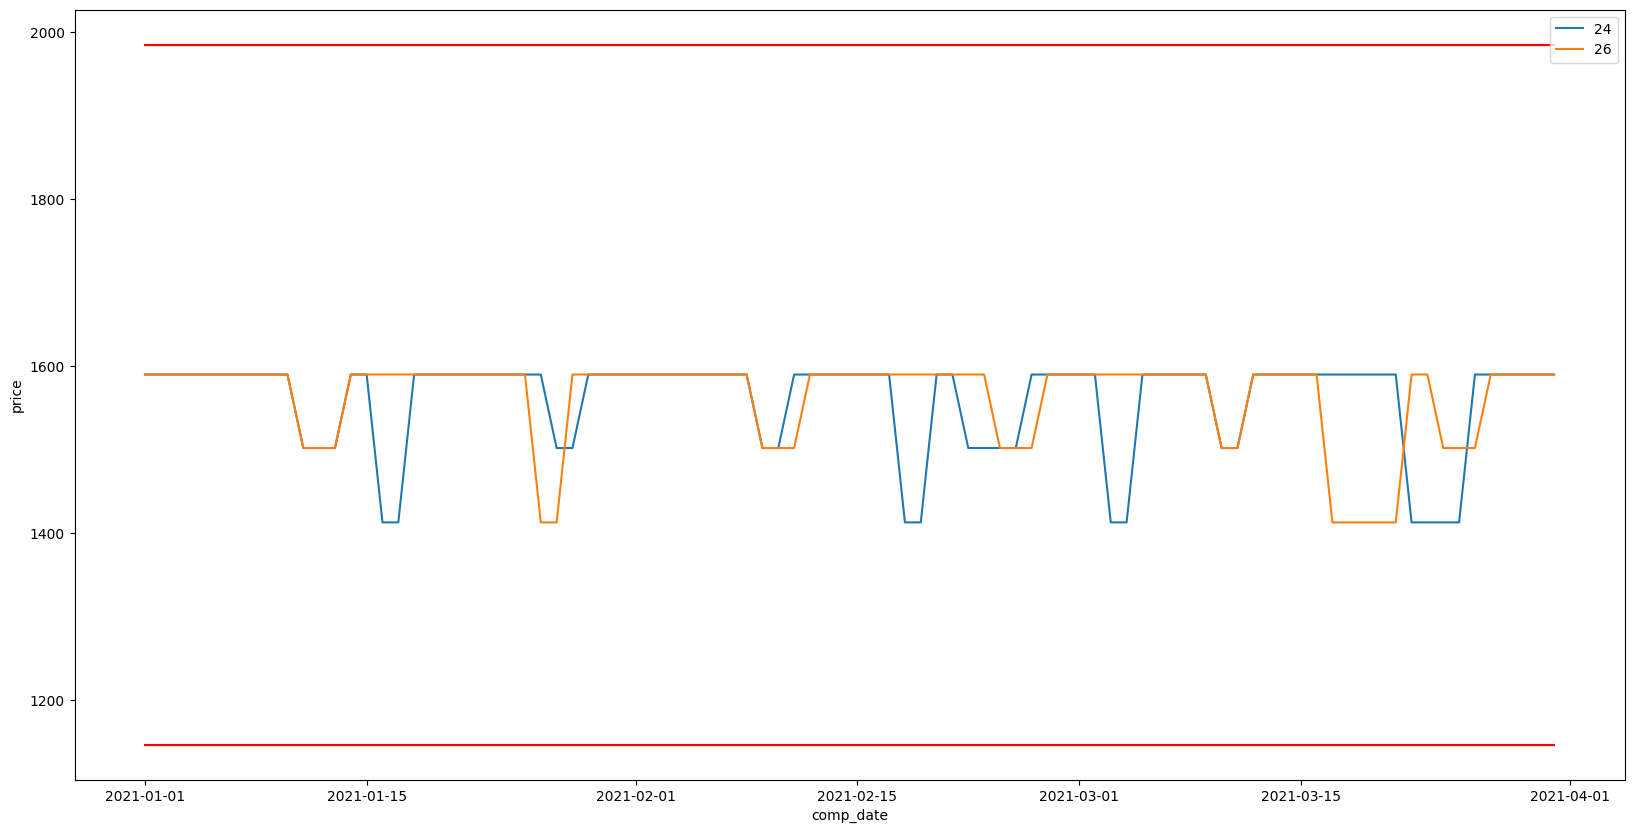

In [103]:
pdfirst['comp_date'] = pd.to_datetime(pdfirst['comp_date'])
plt.figure(figsize=(20,10))
df = pdfirst[(pdfirst.product_id == 111853) & (pdfirst.seller_id.isin([24,26]))]
sns.lineplot(data = df, x = 'comp_date', y='price', hue='seller_id', palette=sns.color_palette("tab10"))
sns.lineplot(data = df, x = 'comp_date', y = 'max(price)', c = 'r')
sns.lineplot(data = df, x = 'comp_date', y = 'min(price)', c = 'r')

# Interpretation of the graph and the result:
After completing the VAR model, we analysed the coefficients representing the various sellers, taking into account the most significant ones. Thanks to this, we know that there is a relationship between the time series. The next step is to identify a granger causality between the sellers, so we moved on to the analysis of the granger causality matrix. For example: with the coefficient analysis, we considered seller 24 and 26. In the matrix, we see if the value is significant (below 0.05) for category 1163. We obtain a significant number and since 26 is on the column and 24 is on the row then we can say that 26 granger causes 24. In fact from the graph we can see this relationship, as the price change of 26 (for a specific product, in this case 111853) is followed by a price change of 24. 


We would like to specify that the analysis was first conducted by aggregating by category, but graphically displayed by product, so it may not represent all products in the individual category. 